In [10]:
!pip install hickle

     |████████████████████████████████| 49 kB 1.2 MB/s            
     |████████████████████████████████| 2.9 MB 3.3 MB/s            
     |████████████████████████████████| 86 kB 1.3 MB/s             
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.5.0 requires h5py~=3.1.0, but you have h5py 2.10.0 which is incompatible.


In [1]:
import os
import pandas as pd
import shutil
import tempfile
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import numpy as np
import PIL
from PIL import Image, ImageChops
import torch
from torch import nn
import torchvision.models
import cv2

from pathlib import Path

import tensorflow as tf
from tensorflow import keras
import matplotlib.patches as patches

In [22]:
!nvidia-smi

Sun Jun  5 22:39:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:06:00.0 Off |                    0 |
| N/A   31C    P8    25W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:07:00.0 Off |                    0 |
| N/A   

### Load Model

In [39]:
fundus_classifier = keras.models.load_model('models/ROP-256x25680-20-split-resnet18-Float16_2-race_detection_rop_seg_data_fundus_rop_seg-0.001_20220419-040552_epoch:021.hdf5')

In [40]:
fundus_classifier

In [2]:
segmentation_classifier = keras.models.load_model('models/MIMIC-256x25680-20-split-resnet-Float16_2-race_detection_rop_seg_data_rop_seg-0.001_20220321-054140_epoch:011.hdf5')

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


In [48]:
fundus_classifier.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           input_2[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_18 (ZeroPadding2 (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_18[0][0]          
_______________________________________________________________________________________

In [46]:
segmentation_classifier.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           input_3[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_68 (ZeroPadding2 (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_68[0][0]          
______________________________________________________________________________________

## Test Classifier

In [98]:
img = Image.open("/users/riya/race/dataset/segmentations/7445.bmp")

In [99]:
arr = np.array(img)

In [100]:
resized = cv2.resize(arr, (256, 256))

### Method 1: 2D image repeated thrice - to make three channels

In [117]:
channels = np.repeat(resized[:, :, np.newaxis], 3, axis=2).reshape((1,256,256,3))

In [118]:
arr.shape, resized.shape, channels.shape

((480, 640), (256, 256), (1, 256, 256, 3))

In [119]:
# unnecessary 
tensor = tf.convert_to_tensor(channels)

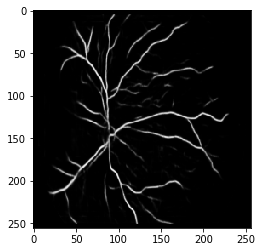

In [120]:
plt.imshow(np.reshape(channels, (256, 256, 3)), interpolation='nearest')
plt.show()

In [121]:
# right pred 
segmentation_classifier(channels)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.0647717, 0.9352283]], dtype=float32)>

In [279]:
tensor = segmentation_classifier(channels)

In [314]:
tensor

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.0647717, 0.9352283]], dtype=float32)>

In [313]:
tensor.numpy()[0,1]

0.9352283

### Method 2: Concatenate zeroed channels

In [122]:
# concatenate zero channels
zeros = np.zeros((256, 256, 1))
resized1 = np.reshape(resized, (256, 256, 1))
resized1.shape

(256, 256, 1)

In [123]:
channels1 = np.concatenate((resized1, zeros, zeros), axis = 2).reshape((1,256,256,3))

In [124]:
channels1.shape

(1, 256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


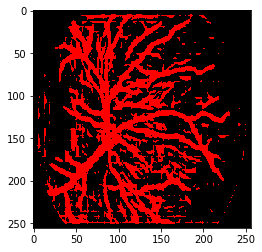

In [125]:
plt.imshow(np.reshape(channels1, (256, 256, 3)), interpolation='nearest')
plt.show()

In [126]:
# wrong pred 
segmentation_classifier(channels1)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.863334  , 0.13666598]], dtype=float32)>

Ok! We know what we want :)

## High Intensity Pixel Images

I need to take images and black out pixels of highest intensity in main and background regions. To do this, I'll first choose some number of images with similar main and background locations (manually), load those into my new folder, and remove high intensity pixels there.

Images: 7393, 7419, 7420, 7423, 7568, 7571, 7575, 7578, 9135, 9153, 9378, 9394, 9540, 9556, 12013, 12018, 12487, 12488, 15880, 18163

### Load Images

In [3]:
ids = [7393, 7419, 7420, 7423, 7568, 7571, 7575, 7578, 9135, 9153, 9378, 9394, 9540, 9556, 12013, 12018, 12487, 12488, 15880, 18163]

In [4]:
csv_path = "/users/riya/race/csv/image_race_data.csv"
data_path = "/users/riya/race/dataset/segmentations/"
intensity_path = "/users/riya/race/classifier_experiments/dataset/high_intensity_experiment2/original/"

In [5]:
def get_images(ids, csv_path, load_path, save_path):
    
    new_df = pd.DataFrame()
    data = pd.read_csv(csv_path)
        
    for i in ids:
        a = shutil.copy(load_path + str(i) + '.bmp', save_path) # solely copying segmentations
        
        df1 = data.loc[data['image_id'] == i]
        new_df = pd.concat([new_df, df1], axis = 0)
    
    return new_df

In [6]:
data20 = get_images(ids, csv_path, data_path, intensity_path)

In [7]:
data20

,subject_id,race,variable,value,image_id,fundus_location,segmentation_location
1019,RCOL-0022-JS,black,posterior,https://tctc.ohsu.edu/uploads/7393.png,7393,7393.png,7393.bmp
3588,RCOL-0026-MM,black,nasal,https://tctc.ohsu.edu/uploads/7419.png,7419,7419.png,7419.bmp
1020,RCOL-0026-MM,black,posterior,https://tctc.ohsu.edu/uploads/7420.png,7420,7420.png,7420.bmp
1021,RCOL-0026-MM,black,posterior,https://tctc.ohsu.edu/uploads/7423.png,7423,7423.png,7423.bmp
1027,RCOL-0042-EW,white,posterior,https://tctc.ohsu.edu/uploads/7568.png,7568,7568.png,7568.bmp
1028,RCOL-0042-EW,white,posterior,https://tctc.ohsu.edu/uploads/7571.png,7571,7571.png,7571.bmp
1029,RCOL-0042-EW,white,posterior,https://tctc.ohsu.edu/uploads/7575.png,7575,7575.png,7575.bmp
1030,RCOL-0042-EW,white,posterior,https://tctc.ohsu.edu/uploads/7578.png,7578,7578.png,7578.bmp
731,OHSU-0006,white,posterior,https://tctc.ohsu.edu/uploads/9135.bmp,9135,9135.png,9135.bmp
735,OHSU-0007,white,posterior,https://tctc.ohsu.edu/uploads/9153.bmp,9153,9153.png,9153.bmp


Immediate note: many more white than black patients.

### Find the Boundary

By looking at the images: 
 * preliminary x: 75 to 125
 * preliminary y: 100 to 150
 
(determined by manually looking at images and finding general patterns in central region location)

In [8]:
def find_boundary(ids, load_path):
    for i in ids:
        img = Image.open(load_path + str(i) + '.bmp')
        resized = cv2.resize(np.array(img), (256, 256))
        
        plt.imshow(resized, interpolation='nearest')
        plt.show()

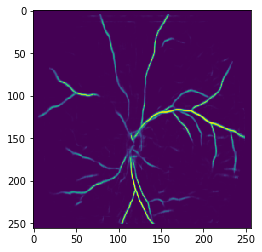

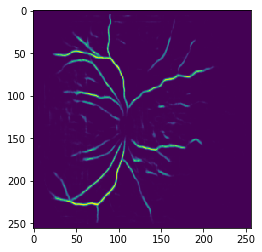

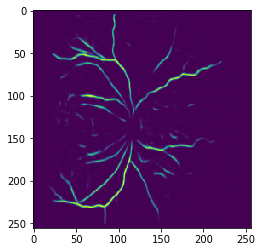

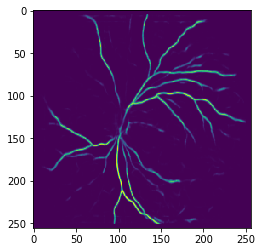

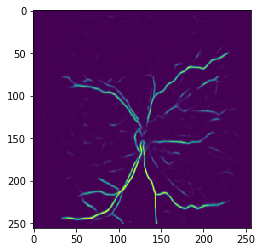

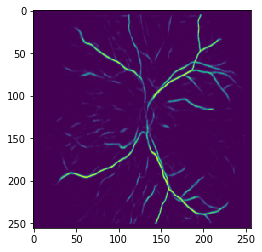

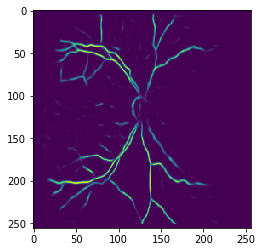

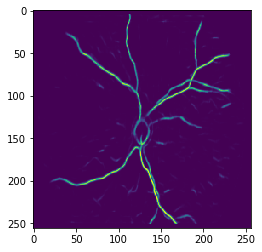

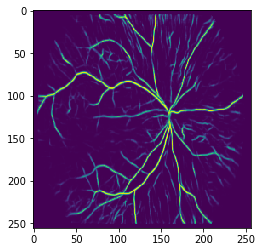

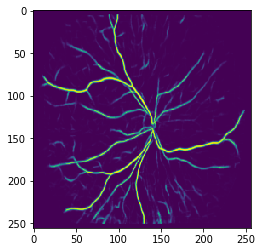

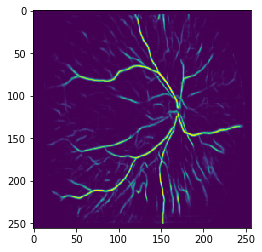

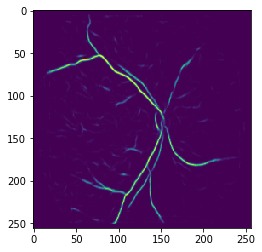

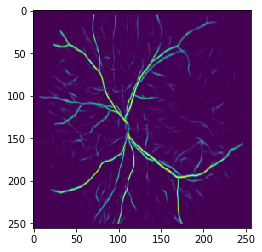

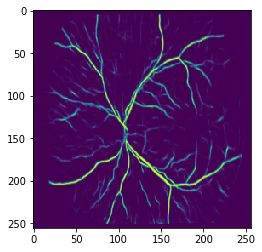

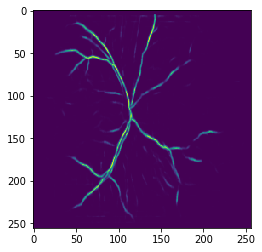

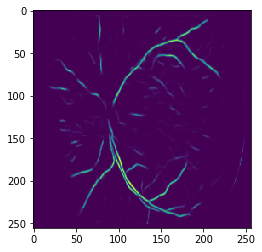

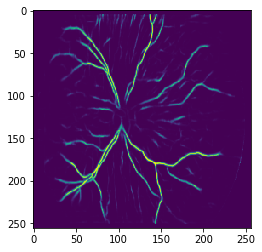

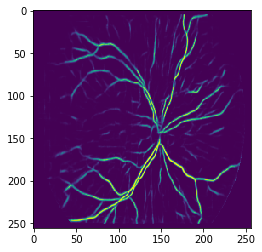

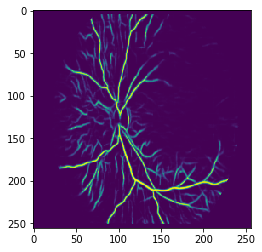

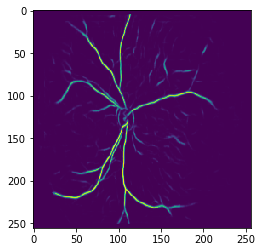

In [9]:
find_boundary(ids, intensity_path)

### Shadow Images

In [10]:
threshold_center_path = "/users/riya/race/classifier_experiments/dataset/high_intensity_experiment2/threshold_center/"
threshold_back_path = "/users/riya/race/classifier_experiments/dataset/high_intensity_experiment2/threshold_back/"

In [11]:
# we want to black out the other region which we do not brighten (overall, by selecting only bright pixels)

def threshold_images(ids, load_path, save_path1, save_path2, threshold, region):
    for i in ids:
        img = Image.open(load_path + str(i) + '.bmp')
        resized = cv2.resize(np.array(img), (256, 256))
        
        x_bottom = 50
        x_top = 150
        
        y_bottom = 75
        y_top = 175
        
        # select brightest pixels from center
        center_arr = resized[y_bottom:y_top, x_bottom:x_top] # idk why switched works?
        bright_center = np.copy(center_arr)
        bright_center[bright_center < threshold] = 0 # goes from 0 to 246
        
            # pad and concat
        bright_center = np.pad(bright_center, ((y_bottom, 256 - y_top), (x_bottom, 256 - x_top)))
        final_center = bright_center

        # prepare background arr
        center_arr = np.pad(center_arr, ((y_bottom, 256 - y_top), (x_bottom, 256 - x_top)))
        back_arr = resized - center_arr # 0 for center pixels
        bright_back = np.copy(back_arr)
        
        # select brightest pixels from background
        bright_back[bright_back < threshold] = 0 # goes from 0 to 246
        final_back = bright_back
        
        if (region == 'center'):
            center_img = Image.fromarray(final_center)
            center_img.save(save_path1 + str(threshold) + '/' + str(i) + '.bmp')
        elif (region == 'background'):
            back_img = Image.fromarray(final_back)
            back_img.save(save_path2 + str(threshold) + '/' + str(i) + '.bmp')
            
        # same filenames because stored in different folders

In [272]:
threshold_images(ids, intensity_path, threshold_center_path, threshold_back_path, 225, 'background')

In [273]:
threshold_images(ids, intensity_path, threshold_center_path, threshold_back_path, 225, 'center')

From the first run, it appears I made the dull region for the center much too small, since dull center is barely any different. We will make the region larger and then test the classifier.

Done that! Increased the region by 25 pixels on both sides.

### Prepare For Classifier

The idea is that I'll return the **prediction for the white class** for dull center, dull back, and more.

In [12]:
def prepare_for_classification(img_id, img_path):
    img = Image.open(img_path + str(img_id) + '.bmp')
    arr = np.array(img)
    resized = cv2.resize(arr, (256, 256))
    channels = np.repeat(resized[:, :, np.newaxis], 3, axis=2).reshape((1,256,256,3))
    
    return channels

In [63]:
# must run to clear arrays 

og_imgs = np.zeros([1, 256, 256, 3], dtype='int')
threshold_back_imgs = np.zeros([1, 256, 256, 3], dtype='int')
threshold_center_imgs = np.zeros([1, 256, 256, 3], dtype='int')

In [64]:
def combine_images(ids, img_path, img_arr):
    for i in ids:
        # original preds
        img_prepared = prepare_for_classification(i, img_path)
        img_arr = np.concatenate((img_arr, img_prepared), axis = 0)
    
    return img_arr

In [65]:
og_imgs = combine_images(ids, intensity_path, og_imgs)
threshold_back_imgs = combine_images(ids, threshold_back_path + "/200/", threshold_back_imgs)
threshold_center_imgs = combine_images(ids, threshold_center_path + "/200/", threshold_center_imgs)

In [66]:
threshold_back_imgs.shape, threshold_center_imgs.shape, og_imgs.shape 

# first prediction is just done with all zeros, i'm not sure how to avoid that.

((21, 256, 256, 3), (21, 256, 256, 3), (21, 256, 256, 3))

### Run Through Classifier & Predictions

In [67]:
preds_df = pd.DataFrame(columns = ['id', 'og_pred', 'threshold_center_pred', 'threshold_back_pred'])

In [68]:
pred_ids = pd.Series(ids)
pred_ids = pd.concat([pd.Series([0]), pred_ids]) # the first prediction is irrelevant, so accounting for that

In [69]:
preds_df['id'] = pred_ids

In [70]:
preds_df.head()

,id,og_pred,threshold_center_pred,threshold_back_pred
0,0,NaN,NaN,NaN
0,7393,NaN,NaN,NaN
1,7419,NaN,NaN,NaN
2,7420,NaN,NaN,NaN
3,7423,NaN,NaN,NaN


In [71]:
def determine_preds(preds_df, name, images):

    num_images = images.shape[0]
    preds_arr = [0] * num_images

    preds = segmentation_classifier(images)
    
    for i in range(num_images):
        preds_arr[i] = preds.numpy()[i, 1] # returning the white prediction for each image
    
    preds_df[name] = preds_arr # weird that not defined in function?

In [72]:
determine_preds(preds_df, 'og_pred', og_imgs)

In [73]:
determine_preds(preds_df, 'threshold_center_pred', threshold_center_imgs)
determine_preds(preds_df, 'threshold_back_pred', threshold_back_imgs)

In [74]:
preds_df

,id,og_pred,threshold_center_pred,threshold_back_pred
0,0,0.918845,0.918845,0.918845
0,7393,0.000611,0.729520,0.152726
1,7419,0.000732,0.454291,0.335786
2,7420,0.000229,0.564474,0.260907
3,7423,0.006811,0.643021,0.130618
4,7568,0.997708,0.693006,0.561703
5,7571,0.995381,0.792544,0.310328
6,7575,0.839800,0.682256,0.416715
7,7578,0.998232,0.698561,0.140513
8,9135,0.999997,0.190649,0.005854


In [75]:
preds_df = preds_df.reset_index()

Very interesting! White predictions seem most impacted by threshold back, seeming to show that the center brightest pixels are most valuable in predicting the white class.

### Save Predictions

In [26]:
def save_df(df, path, threshold):    
    df.to_csv(path + "preds" + str(threshold) + ".csv") 

In [27]:
csv_path = "/users/riya/race/classifier_experiments/predictions/high_intensity_experiment2/"

In [28]:
save_df(preds_df, csv_path, 225)

## Analyze Predictions

In [29]:
white_preds = preds_df.iloc[5:]

In [30]:
white_preds

,index,id,og_pred,threshold_center_pred,threshold_back_pred
5,4,7568,0.997708,0.807309,0.769037
6,5,7571,0.995381,0.690559,0.584053
7,6,7575,0.839800,0.918845,0.898633
8,7,7578,0.998232,0.801392,0.926370
9,8,9135,0.999997,0.198880,0.010839
10,9,9153,0.999586,0.316396,0.105211
11,10,9378,0.999997,0.738245,0.234626
12,11,9394,0.999245,0.803637,0.821188
13,12,9540,0.999988,0.543136,0.427770
14,13,9556,0.999993,0.599577,0.072867


In [31]:
len(white_preds)

16

In [32]:
white_preds.mean()

index                       11.500000
id                       10593.562500
og_pred                      0.988808
threshold_center_pred        0.711904
threshold_back_pred          0.500552
dtype: float64

In [33]:
white_preds[white_preds['threshold_back_pred'] > .5]

,index,id,og_pred,threshold_center_pred,threshold_back_pred
5,4,7568,0.997708,0.807309,0.769037
6,5,7571,0.995381,0.690559,0.584053
7,6,7575,0.839800,0.918845,0.898633
8,7,7578,0.998232,0.801392,0.926370
12,11,9394,0.999245,0.803637,0.821188
15,14,12013,0.995826,0.918845,0.814717
16,15,12018,0.995558,0.876740,0.895979
17,16,12487,0.999854,0.813535,0.601655


In [34]:
white_preds[white_preds['threshold_back_pred'] < .5]

,index,id,og_pred,threshold_center_pred,threshold_back_pred
9,8,9135,0.999997,0.198880,0.010839
10,9,9153,0.999586,0.316396,0.105211
11,10,9378,0.999997,0.738245,0.234626
13,12,9540,0.999988,0.543136,0.427770
14,13,9556,0.999993,0.599577,0.072867
18,17,12488,0.999981,0.911338,0.445967
19,18,15880,0.999834,0.658610,0.072308
20,19,18163,0.999942,0.793426,0.327615


In [35]:
white_preds[white_preds['threshold_center_pred'] < .5]

,index,id,og_pred,threshold_center_pred,threshold_back_pred
9,8,9135,0.999997,0.198880,0.010839
10,9,9153,0.999586,0.316396,0.105211


In [36]:
avg_test = white_preds[white_preds['threshold_center_pred'] > .5]

In [37]:
avg_test.mean()

index                       11.928571
id                       10800.642857
og_pred                      0.987239
threshold_center_pred        0.776799
threshold_back_pred          0.563770
dtype: float64

## Nice Graphics

To save time in matplotlib making, we can set default parameters that we like.

In [38]:
pylab.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

In [76]:
params = {'axes.titlesize':15,
          'axes.titlepad':10,
        'axes.labelsize': 20,
         'axes.labelpad':20,}
pylab.rcParams.update(params)

In [77]:
def trichart(preds, og_arr, center_arr, back_arr, boxes):
    
    for i in range(len(og_arr)):
        
        f, axarr = plt.subplots(1,3)
        axarr[0].imshow(og_arr[i])
        axarr[1].imshow(center_arr[i])
        axarr[2].imshow(back_arr[i])
        
        #size
        fig = plt.gcf()
        fig.set_size_inches(15, 15) # max is jupyter width i think
        
        # whole plot title (unneeded)
        # img_id = preds['id'][i]
        # fig.suptitle("Image ID:" + str(img_id))
        
        # subplot titles
        
        axarr[0].set_title('Original Image')
        axarr[1].title.set_text('Brightest Center Pixels')
        axarr[2].title.set_text('Brightest Background Pixels')
        
        # subplot predictions
        axarr[0].set_xlabel(round(preds['og_pred'][i], 5)) # also conveniently rounding
        axarr[1].set_xlabel(round(preds['threshold_center_pred'][i], 5))
        axarr[2].set_xlabel(round(preds['threshold_back_pred'][i], 5))
        
        # threshold region boxes
        rect = patches.Rectangle((50, 75), 100, 100, linewidth=2, edgecolor='r', facecolor='none')
        axarr[0].add_patch(rect)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


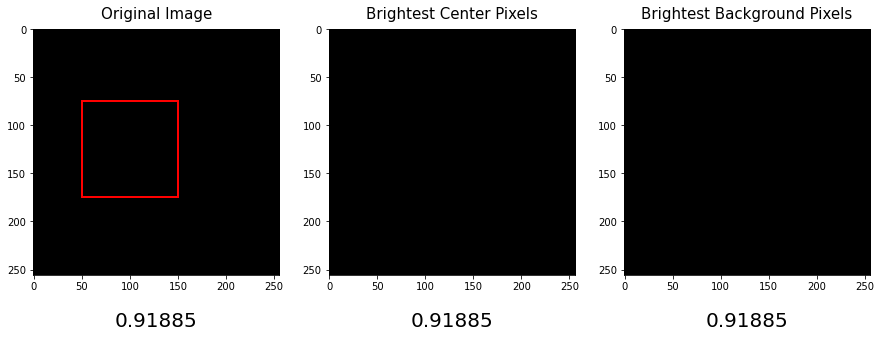

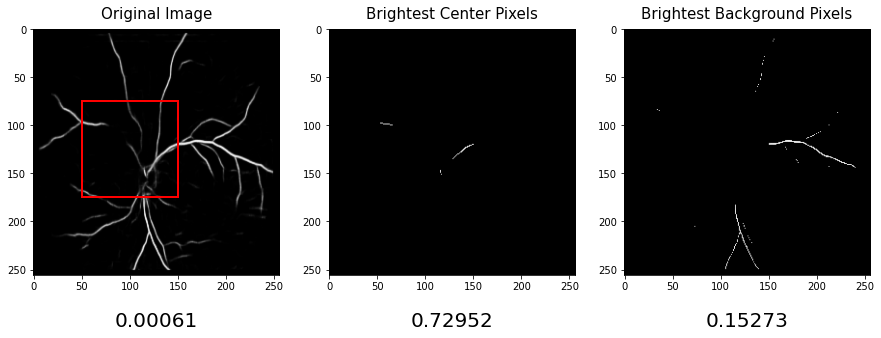

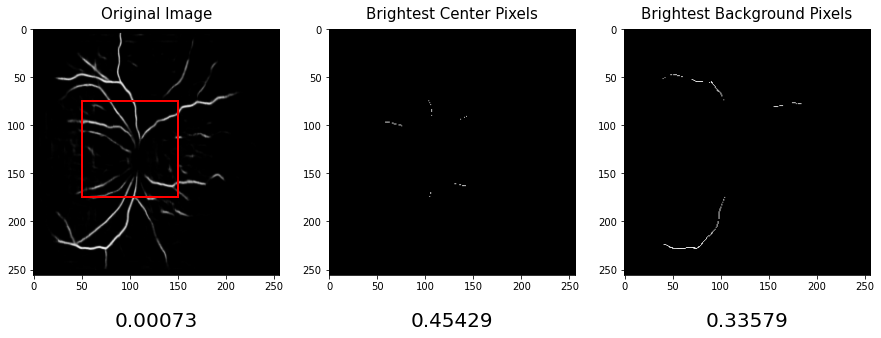

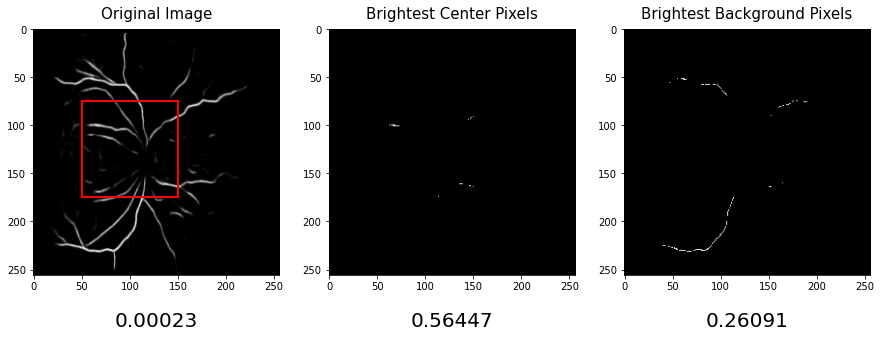

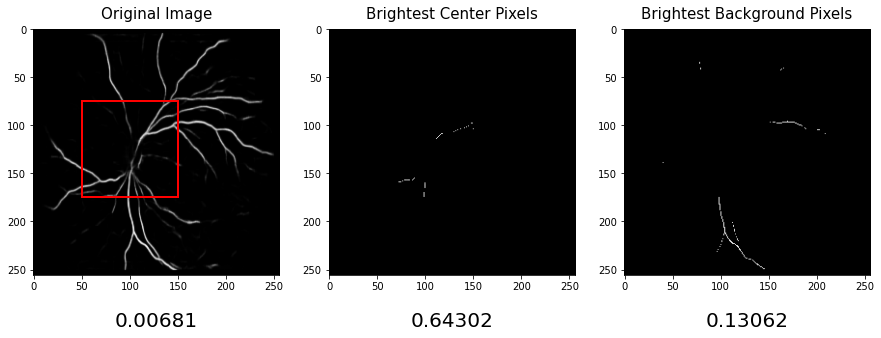

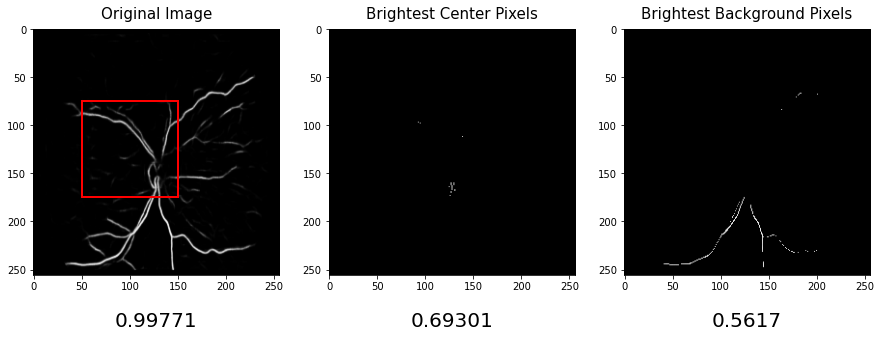

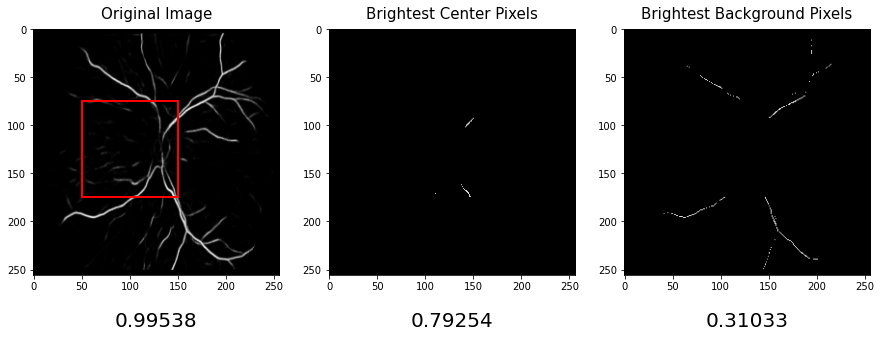

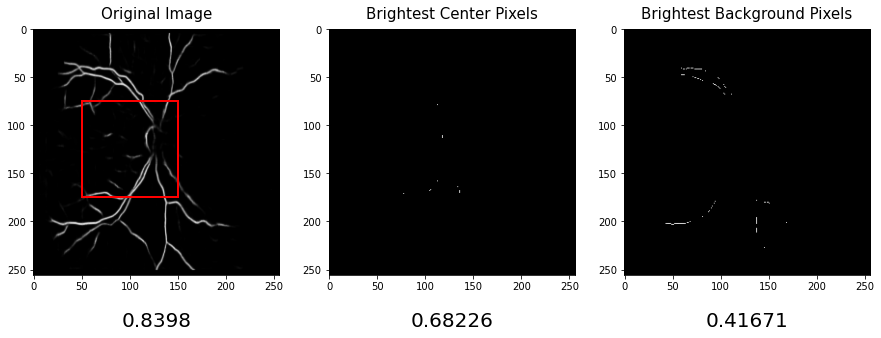

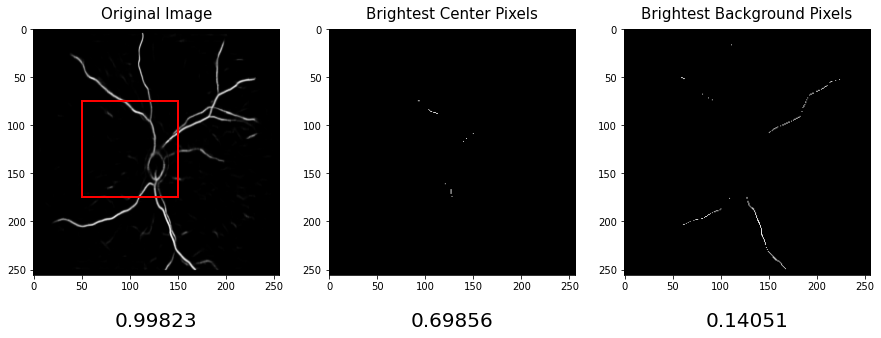

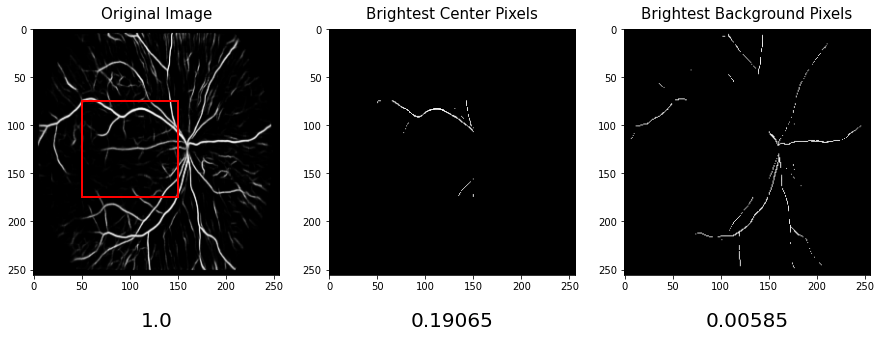

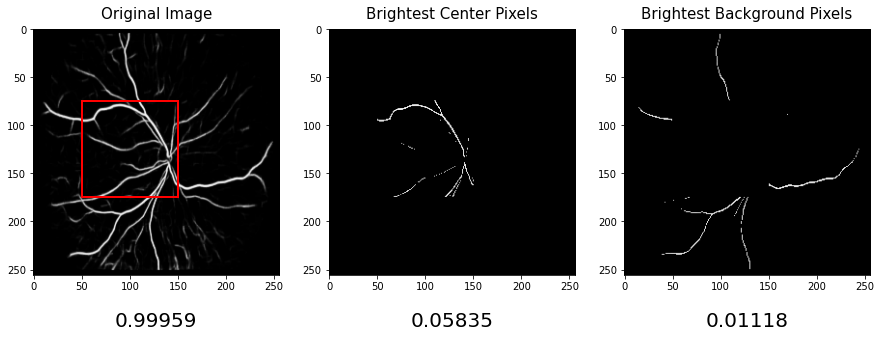

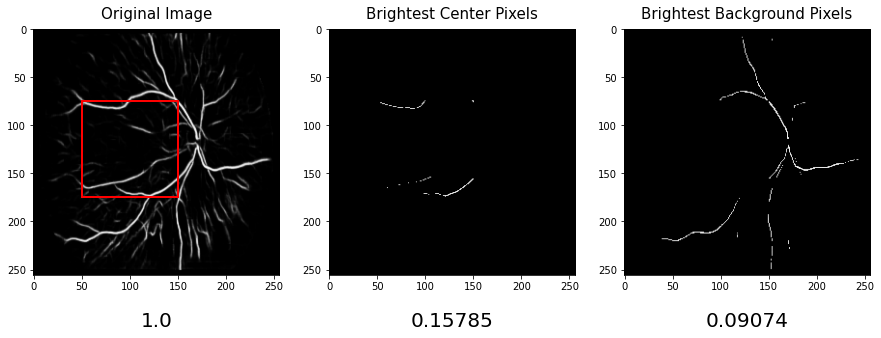

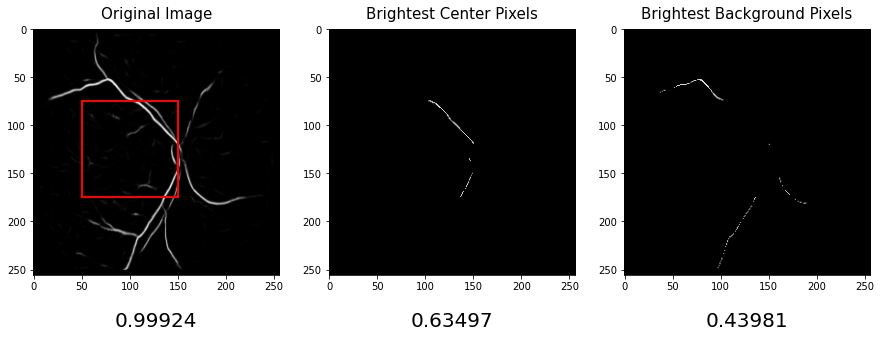

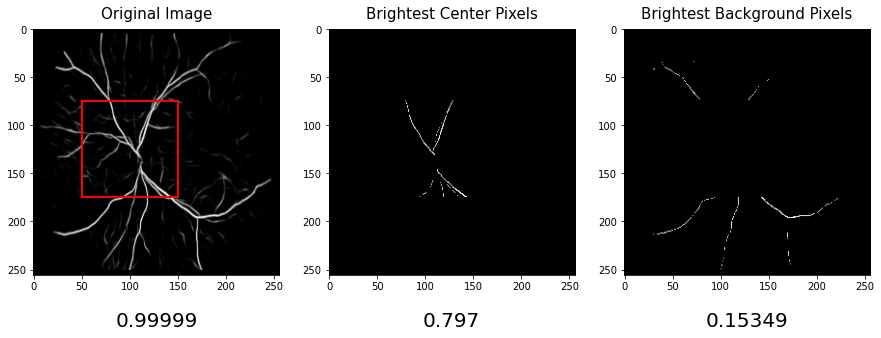

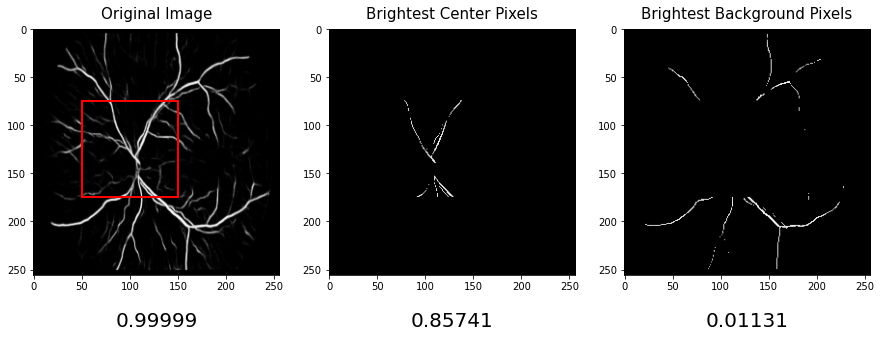

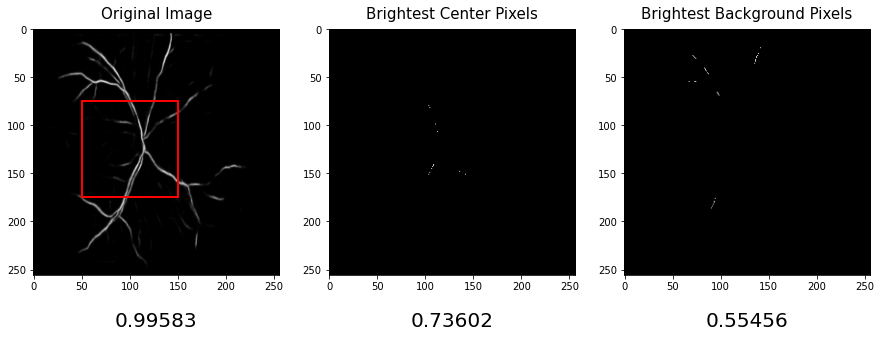

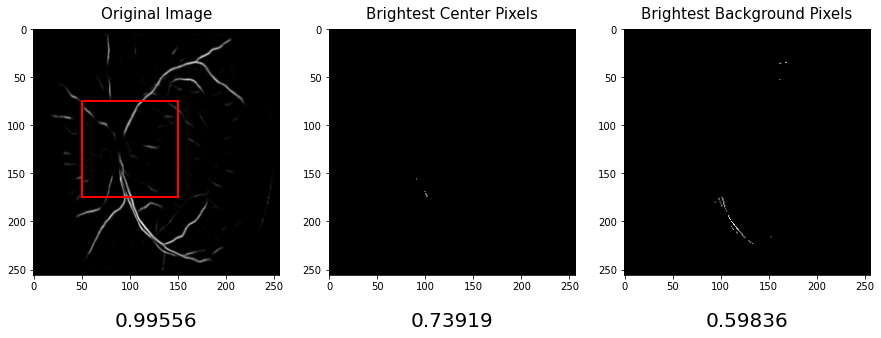

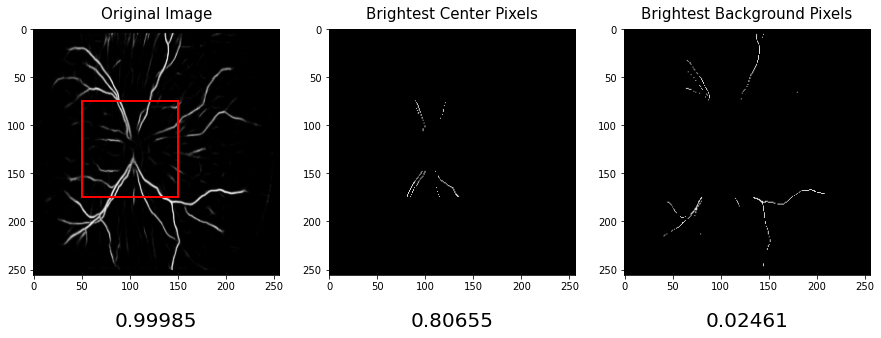

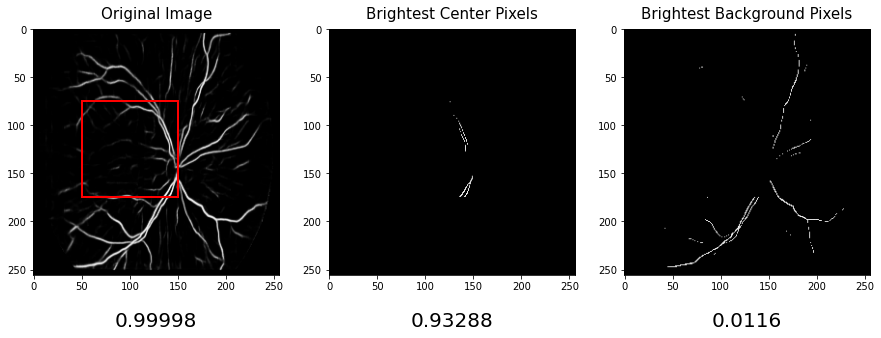

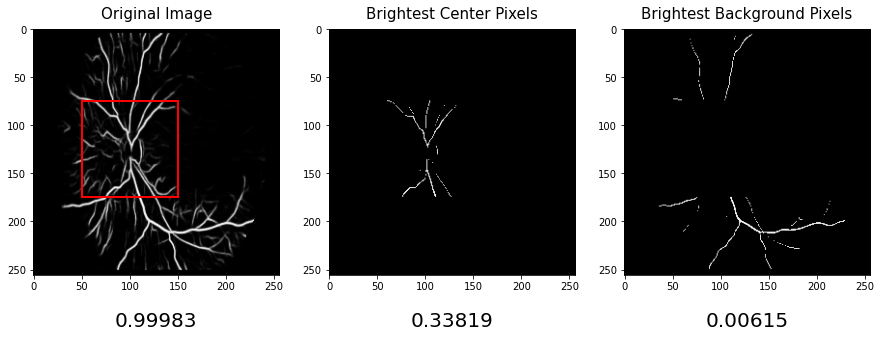

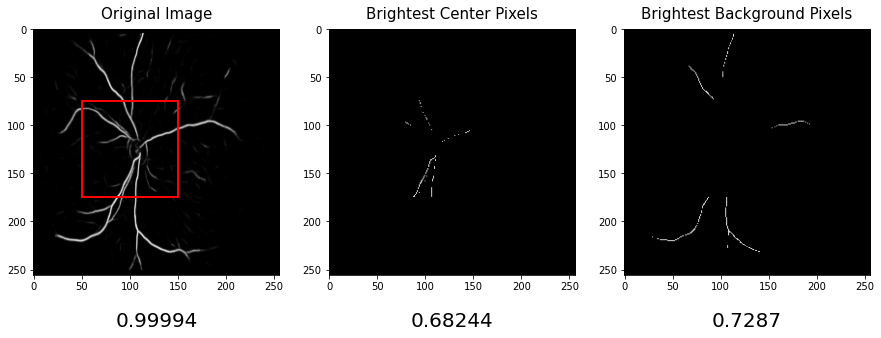

In [78]:
trichart(preds_df, og_imgs, threshold_center_imgs, threshold_back_imgs, True)